In [10]:
from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq

# llm = ChatGroq(model="llama-3.2-90b-vision-preview")
llm = ChatOllama(model="llama3.2")

In [11]:
from pydantic import BaseModel
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage

class People(BaseModel):
  results: list[str]
  
class Places(BaseModel):
  results: list[str]
  
class State(BaseModel):
  # people: People
  # places: Places
  topic: str
  people: list[str] = None
  places: list[str] = None
  
llm_with_structure = llm.with_structured_output(Places, include_raw=True) 




In [12]:

try: 
  print("this")
  resp = llm_with_structure.invoke([SystemMessage(content="think of any associations with a bird and places")])
except Exception as e:
  error = e
  print('wtf')
  
resp
  

this


{'raw': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-29T19:25:37.4564449Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 48299700, 'load_duration': 27721900, 'prompt_eval_count': 57, 'prompt_eval_duration': 18845000, 'eval_count': 1, 'eval_duration': 31000}, id='run-ff7cffdd-74b3-43f2-bb79-776194c6d124-0', usage_metadata={'input_tokens': 57, 'output_tokens': 1, 'total_tokens': 58}),
 'parsed': None,
 'parsing_error': None}

In [13]:
resp.keys()


dict_keys(['raw', 'parsed', 'parsing_error'])

In [14]:
while True:
  resp = llm_with_structure.invoke("think of any associations with a bird and places")
  print("===" * 25)
  print(resp)
  if not resp['parsing_error']:
    break

if resp.get('parsing_error'):
  print('heya!')
  
resp

{'raw': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-29T19:25:38.2585205Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'Places', 'arguments': {'results': '["Nesting Site", "Migratory Stopover", "Breeding Ground"]'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 764011900, 'load_duration': 25671500, 'prompt_eval_count': 153, 'prompt_eval_duration': 160339000, 'eval_count': 32, 'eval_duration': 576370000}, id='run-bf10be91-f903-498e-b783-37def5993e81-0', tool_calls=[{'name': 'Places', 'args': {'results': '["Nesting Site", "Migratory Stopover", "Breeding Ground"]'}, 'id': '09a2cb9e-d6af-4af7-9d54-22d1d17c65c7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 32, 'total_tokens': 185}), 'parsing_error': 1 validation error for Places
results
  Input should be a valid list [type=list_type, input_value='["Nesting Site", "Migrat...er", "Breeding Groun

{'raw': AIMessage(content='{"name":"Places","parameters":{"results":[{"type":"string","default":"","value":"Nesting sites"}}', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-29T19:25:40.6540497Z', 'message': {'role': 'assistant', 'content': '{"name":"Places","parameters":{"results":[{"type":"string","default":"","value":"Nesting sites"}}'}, 'done_reason': 'stop', 'done': True, 'total_duration': 436571000, 'load_duration': 23602100, 'prompt_eval_count': 153, 'prompt_eval_duration': 19837000, 'eval_count': 22, 'eval_duration': 391952000}, id='run-ad975d09-d435-4451-a610-454b856fe4e9-0', usage_metadata={'input_tokens': 153, 'output_tokens': 22, 'total_tokens': 175}),
 'parsed': None,
 'parsing_error': None}

In [15]:
resp['parsed']

In [16]:
resp


{'raw': AIMessage(content='{"name":"Places","parameters":{"results":[{"type":"string","default":"","value":"Nesting sites"}}', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-29T19:25:40.6540497Z', 'message': {'role': 'assistant', 'content': '{"name":"Places","parameters":{"results":[{"type":"string","default":"","value":"Nesting sites"}}'}, 'done_reason': 'stop', 'done': True, 'total_duration': 436571000, 'load_duration': 23602100, 'prompt_eval_count': 153, 'prompt_eval_duration': 19837000, 'eval_count': 22, 'eval_duration': 391952000}, id='run-ad975d09-d435-4451-a610-454b856fe4e9-0', usage_metadata={'input_tokens': 153, 'output_tokens': 22, 'total_tokens': 175}),
 'parsed': None,
 'parsing_error': None}

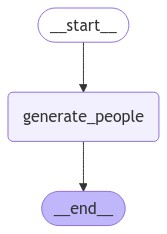

In [20]:

from langgraph.graph import StateGraph, START, END
from pydantic_core import ValidationError
import time

builder = StateGraph(State)

def generate_people_try_catch(state):
  places_prompt = f"""Given the topic ({state.topic}), think of any associations with places"""
  
  while True:
    
    start_time = time.time()
    try:
      print("-----  trying again -----")
      places = llm_with_structure.invoke(places_prompt)
      print(places)
      break  
    except ValidationError as e:
      print(f"There was a  excpetion with == {e.title} ==\n\n")
      print(e.errors())
    finally:
      end_time = time.time()
      time_took = end_time - start_time
      print("---" * 25)

      print(f"Time to generate output and retry: {time_took}")    
      print("---" * 25)
    
  return {
    'places': places.results
  }

builder.add_node('generate_people', generate_people_try_catch)
builder.add_edge(START, 'generate_people')
builder.add_edge('generate_people', END)

graph = builder.compile()

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


In [21]:

res = graph.invoke({'topic': "bird"})

-----  trying again -----
{'raw': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-29T19:26:38.5152666Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'Places', 'arguments': {'results': '["Birds and Blooms National Wildlife Refuge in Florida", "Cape May Bird Observatory in New Jersey", "Hawk Mountain Sanctuary in Pennsylvania"]'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 894006800, 'load_duration': 22077600, 'prompt_eval_count': 156, 'prompt_eval_duration': 20310000, 'eval_count': 45, 'eval_duration': 850409000}, id='run-c239baaf-4d6b-4e89-b352-d6e202dd6fcc-0', tool_calls=[{'name': 'Places', 'args': {'results': '["Birds and Blooms National Wildlife Refuge in Florida", "Cape May Bird Observatory in New Jersey", "Hawk Mountain Sanctuary in Pennsylvania"]'}, 'id': 'c0d81bf5-2ae6-4e1d-b0b9-3594397ce8cb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 156, 'output_toke

KeyError: 'results'

In [192]:
res

{'topic': 'bird',
 'places': ['https://en.wikipedia.org/wiki/Ibiza',
  'https://en.wikipedia.org/wiki/Sardinia',
  'https://en.wikipedia.org/wiki/Canary_Islands',
  'https://en.wikipedia.org/wiki/Sicily']}

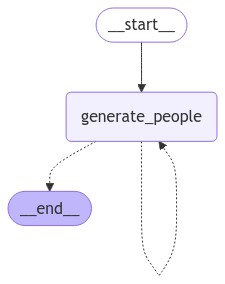

In [22]:
from typing import Literal

# don't throw exception.
llm_with_structure = llm.with_structured_output(Places, include_raw=True) 
  
class StateWithError(BaseModel):
  # people: People
  # places: Places
  topic: str
  people: list[str] = None
  places: list[str] = None
  has_error: bool = False
  
node_builder = StateGraph(StateWithError)

# node
def generate_people(state):
  places_prompt = f"""Given the topic ({state.topic}), think of any associations with places"""
  places = llm_with_structure.invoke(places_prompt)
  print('===' * 25)
  print(places)
  if places.get('parsing_error'):
    print('== H' * 25)
    return {
      'has_error': True
    }
  print("==== WHy the fuck return this?")
  return {
    'places': places.values,
    'has_error': False
  }
  
# edge
def validation_condition(state) -> Literal["generate_people", "__end__"]:
  if state.has_error:
    return "generate_people"
  else:
    return "__end__"
    
node_builder.add_node(generate_people)

node_builder.add_edge(START, 'generate_people')
node_builder.add_conditional_edges('generate_people', validation_condition)

node_graph = node_builder.compile()
display(Image(node_graph.get_graph().draw_mermaid_png()))
  

In [23]:
res = node_graph.invoke({'topic': "bird"})

{'raw': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-29T19:27:02.4469765Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'Places', 'arguments': {'results': '["United States", "Canada", "Mexico", "Australia", "New Zealand"]'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 714853200, 'load_duration': 25467600, 'prompt_eval_count': 156, 'prompt_eval_duration': 28032000, 'eval_count': 32, 'eval_duration': 660029000}, id='run-e51e29e0-f6ce-417c-975f-6d791ce1bc02-0', tool_calls=[{'name': 'Places', 'args': {'results': '["United States", "Canada", "Mexico", "Australia", "New Zealand"]'}, 'id': '1db73bd0-ac88-49c6-ab8e-2959ce8a8a57', 'type': 'tool_call'}], usage_metadata={'input_tokens': 156, 'output_tokens': 32, 'total_tokens': 188}), 'parsing_error': 1 validation error for Places
results
  Input should be a valid list [type=list_type, input_value='["United States", "Canad...trali

ValidationError: 1 validation error for StateWithError
places
  Input should be a valid list [type=list_type, input_value=<built-in method values o...t at 0x000001C4167D8600>, input_type=builtin_function_or_method]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type